# HSCT survival clustered linear regression

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import root_mean_squared_error

training_features_df_file='./data/processed/02.1-scaled_encoded_training_features_df.parquet'
training_labels_df_file='./data/processed/02.1-scaled_encoded_training_labels_df.parquet'

model_file='./models/03.1-linear_regression.pkl'
classifier_model_file='./models/03.2-EFS_classifier_model.pkl'
cluster_regression_models_file='./models/03.2-cluster_regression_models.pkl'

## 1. Load data

Features: (28800, 178)
Labels: (28800, 2)


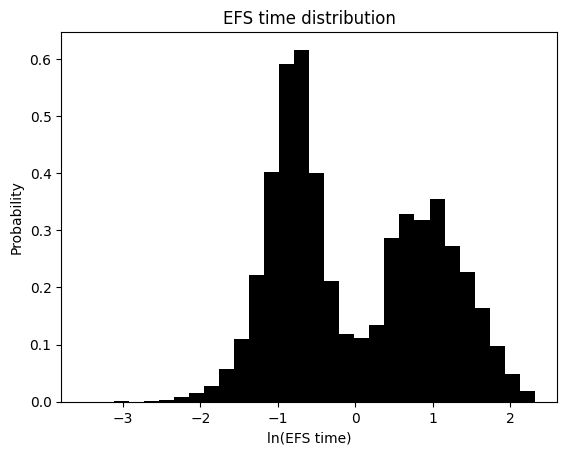

In [2]:
# Load the datasets
features_df=pd.read_parquet(training_features_df_file)
labels_df=pd.read_parquet(training_labels_df_file)

# Remove id column from training features
features_df.drop('ID', axis=1, inplace=True)

print(f'Features: {features_df.shape}')
print(f'Labels: {labels_df.shape}')

plt.title('EFS time distribution')
plt.hist(labels_df['efs_time'], density=True, bins=30, color='black')
plt.xlabel('ln(EFS time)')
plt.ylabel('Probability')
plt.show()

## 2. Make naive linear regression predictions

In [3]:
# Load the baseline linear regression model
with open(model_file, 'rb') as input_file:
    regression_model=pickle.load(input_file)

# Make predictions for the whole training set
predictions=regression_model.predict(features_df)

predictions_df=pd.DataFrame.from_dict({
    'EFS time': labels_df['efs_time'],
    'Predicted EFS time': predictions
})

rmse=root_mean_squared_error(labels_df['efs_time'],predictions)
results={'Naive linear regression': rmse}
print(f'Naive linear regression RMSE: {rmse:.3f}')

Naive linear regression RMSE: 0.911


## 3. Plot results by EFS label

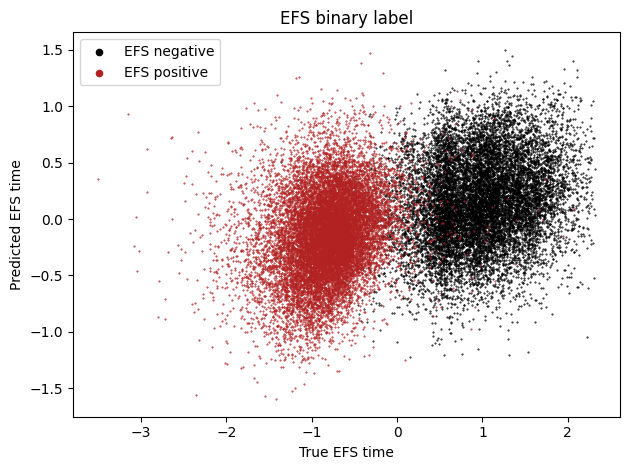

In [ ]:
predictions_df['Predicted EFS time']=predictions
predictions_df['EFS time']=labels_df['efs_time']
predictions_df['EFS']=labels_df['efs']

efs_neg=predictions_df[predictions_df['EFS'] == 0]
efs_pos=predictions_df[predictions_df['EFS'] == 1]

# Plot the results
plt.title('Linear regression results with EFS binary label')
plt.scatter(efs_neg['EFS time'], efs_neg['Predicted EFS time'], s=0.2, label='EFS negative', c='black')
plt.scatter(efs_pos['EFS time'], efs_pos['Predicted EFS time'], s=0.2, label='EFS positive', c='firebrick')
plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.legend(loc='best', markerscale=10)

plt.tight_layout()
plt.show()

## 4. Learn EFS binary label

### 4.1. Train test split

In [ ]:
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features_df, 
    labels_df['efs'],
    test_size=0.33,
    random_state=315
)

### 4.2. Hyperaparameter tune gradient boosting classifier

In [ ]:
# Instantiate the model
model=GradientBoostingClassifier(random_state=315)

# Define the cross-validation strategy
cross_validation=KFold(n_splits=7, shuffle=True, random_state=315)

# Define the hyperparameter search space
distributions={
    'learning_rate': stats.uniform(loc=0.00001, scale=0.00999),
    'n_estimators': list(range(10, 500)),
    'max_depth': list(range(5, 20)),
    'min_samples_split': list(range(2, 100)),
    'min_samples_leaf': list(range(1, 100)),
    'subsample': stats.uniform(loc=0.5, scale=0.5)
}

# Set-up the search
search=RandomizedSearchCV(
    model,
    distributions,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=cross_validation,
    n_iter=100,
    random_state=315,
    return_train_score=True
)

search_results=search.fit(training_features, training_labels)
print(f'Best hyperparameters: {search_results.best_params_}')

### 4.3. Evaluate test set performance

In [ ]:
round_one_classifier=GradientBoostingClassifier(**search_results.best_params_, random_state=315)
result=round_one_classifier.fit(training_features, training_labels)
predictions=round_one_classifier.predict(testing_features)

# Calculate precision and recall
precision=precision_score(testing_labels, predictions)
recall=recall_score(testing_labels, predictions)

# Plot the confusion matrix
cm=confusion_matrix(testing_labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['EFS negative', 'EFS positive'])
_=cm_disp.plot()

plt.title('Test set classifier performance')
plt.tight_layout()
plt.show()

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

### 4.4. Train and label whole dataset

In [ ]:
round_one_classifier=GradientBoostingClassifier(**search_results.best_params_, random_state=315)
result=round_one_classifier.fit(features_df, labels_df['efs'])

with open(classifier_model_file, 'wb') as output_file:
    pickle.dump(round_one_classifier, output_file)

predictions_df['Round 1 learned cluster']=round_one_classifier.predict(features_df)
predictions_df.head()

In [ ]:
# Plot the results
fig, axs=plt.subplots(1,2, figsize=(8,4))
axs=axs.flatten()

fig.suptitle('Round 1 clustering')

axs[0].set_title('Actual vs predicted EFS time')

# Split the data by learned cluster
cluster_zero=predictions_df[predictions_df['Round 1 learned cluster'] == 0]
cluster_one=predictions_df[predictions_df['Round 1 learned cluster'] == 1]

axs[0].scatter(cluster_zero['EFS time'], cluster_zero['Predicted EFS time'], s=0.2, label='EFS negative', c='black')
axs[0].scatter(cluster_one['EFS time'], cluster_one['Predicted EFS time'], s=0.2, label='EFS positive', c='firebrick')

axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')
axs[0].legend(loc='best', markerscale=10)

axs[1].set_title('EFS classifier performance')

# Calculate precision and recall
precision=precision_score(predictions_df['EFS'], predictions_df['Round 1 learned cluster'])
recall=recall_score(predictions_df['EFS'], predictions_df['Round 1 learned cluster'])

# Plot the confusion matrix
cm=confusion_matrix(predictions_df['EFS'], predictions_df['Round 1 learned cluster'], normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['EFS negative', 'EFS positive'])
_=cm_disp.plot(ax=axs[1])

plt.tight_layout()
plt.show()

print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

## 5. Regression in clusters

### 5.1. Split data by learned cluster assignment

In [ ]:
features_df['Round 1 learned cluster']=predictions_df['Round 1 learned cluster']

clustered_features={
    'Cluster zero': features_df[features_df['Round 1 learned cluster'] == 0].copy(),
    'Cluster one': features_df[features_df['Round 1 learned cluster'] == 1].copy()
}

labels_df['Round 1 learned cluster']=predictions_df['Round 1 learned cluster']

clustered_labels={
    'Cluster zero': labels_df[labels_df['Round 1 learned cluster'] == 0].copy(),
    'Cluster one': labels_df[labels_df['Round 1 learned cluster'] == 1].copy()
}

### 5.2. Cluster regression

In [ ]:
round_one_regression_models={
    'Cluster zero': LinearRegression(),
    'Cluster one': LinearRegression()
}

predictions={}

for cluster in clustered_features.keys():

    if cluster == 'Cluster zero':
        features=np.array(clustered_features[cluster])**2

    elif cluster == 'Cluster one':
        features=clustered_features[cluster]

    round_one_regression_models[cluster].fit(features, clustered_labels[cluster]['efs_time'])
    predictions[cluster]=round_one_regression_models[cluster].predict(features)

with open(cluster_regression_models_file, 'wb') as output_file:
    pickle.dump(round_one_regression_models, output_file)

joined_predictions=[]
joined_labels=[]

for cluster in clustered_features.keys():
    joined_predictions.extend(predictions[cluster])
    joined_labels.extend(clustered_labels[cluster]['efs_time'])
    
rmse=root_mean_squared_error(joined_labels, joined_predictions)
results['Round 1 clustered regression']=rmse

plt.title('Actual vs predicted EFS time')

colors=['black', 'firebrick']

for cluster, color in zip(clustered_features.keys(), colors):
    plt.scatter(clustered_labels[cluster]['efs_time'], predictions[cluster], s=0.2, c=color, label=cluster)

plt.xlabel('True EFS time')
plt.ylabel('Predicted EFS time')
plt.legend(loc='best', markerscale=10)
plt.show()

for key, value in results.items():
    print(f'{key} RMSE: {value:.3f}')

In [ ]:
joined_labels=np.array(joined_labels)
joined_predictions=np.array(joined_predictions)

# Plot the results
fig, axs=plt.subplots(1,3, figsize=(10,4))
axs=axs.flatten()

fig.suptitle('Linear regression model performance')

axs[0].set_title('Actual vs predicted EFS time')
axs[0].scatter(joined_labels, joined_predictions, color='black', s=0.2)
axs[0].set_xlabel('True EFS time')
axs[0].set_ylabel('Predicted EFS time')

axs[1].set_title('EFS residual as a function of fitted value')
axs[1].scatter(
    joined_predictions, 
    joined_labels - joined_predictions,
    color='black',
    s=0.2
)
axs[1].set_xlabel('EFS time')
axs[1].set_ylabel('true - predicted EFS time')

axs[2].set_title('Normal quantile plot')
stats.probplot(joined_labels - joined_predictions, plot=axs[2])
axs[2].get_lines()[0].set_markeredgecolor('black')
axs[2].get_lines()[0].set_markerfacecolor('black')
axs[2].set_xlabel('Normal quantiles')
axs[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()